<a href="https://colab.research.google.com/github/NLP-END3/Session3/blob/main/Session3_Pytorch101_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Problem Statement

Write a neural network that can:

1. take 2 inputs:
    - an image from the MNIST dataset (say 5), and
    - a random number between 0 and 9, (say 7)
2. and gives two outputs:
    - the "number" that was represented by the MNIST image (predict 5), and
    - the "sum" of this number with the random number and the input image to the network (predict 5 + 7 = 12)
3. you can mix fully connected layers and convolution layers
4. you can use one-hot encoding to represent the random number input as well as the "summed" output.  
    a. Random number (7) can be represented as 0 0 0 0 0 0 0 1 0 0  
    b. Sum (13) can be represented as: 1. 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0  
    c. 0b1101 (remember that 4 digits in binary can at max represent 15, so we may need to go for 5 digits. i.e. 10010  

## 2. Importing required libraries & Checking GPU


In [1]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

print(torch.cuda.is_available())  # Checks if GPU is available
print(torch.cuda.get_device_name(0)) # Name of GPU
print(torch.cuda.device_count())

True
Tesla K80
1


## 3. Importing MNIST dataset from pytorch

In [2]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

mnist_train = datasets.MNIST('../data',train=True,download=True) # Train dataset
mnist_test = datasets.MNIST('./data',train=False,download=True) # Test dataset

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 3. Plotting few samples of the downloaded data

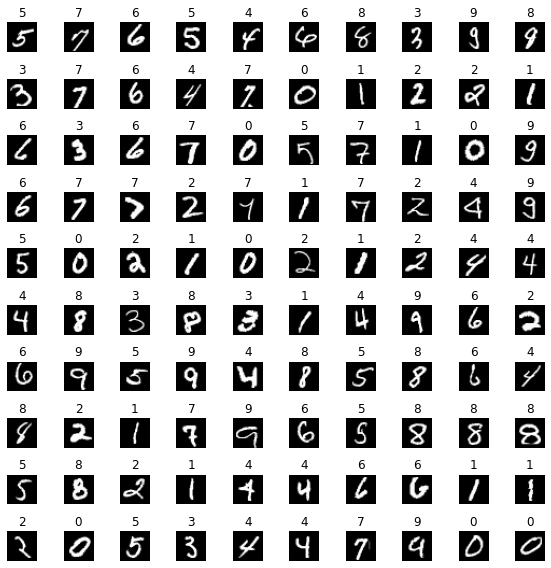

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
figure.tight_layout()
plt.show()

In [4]:
#dir(mnist_train)

## 4. Checking the size of the image, label and image information

In [5]:
print(f'Number of examples in training dataset :{len(mnist_train)}')
print(f'Shape of the training dataset - images : {mnist_train.data.shape}')
print(f'Labels in the training dataset : {mnist_train.targets}')

Number of examples in training dataset :60000
Shape of the training dataset - images : torch.Size([60000, 28, 28])
Labels in the training dataset : tensor([5, 0, 4,  ..., 5, 6, 8])


## 5. Defining Custom Dataset Class

In [6]:
from torch.utils.data import Dataset
from random import randrange

# Dataset is there to be able to interact with DataLoader

class MyDataset(Dataset):
  def __init__(self, inpDataset, transform):
    self.inpDataset = inpDataset
    self.transform = transform

  def __getitem__(self, index):
    randomNumber = randrange(10)
    sample_image, label = self.inpDataset[index]
    if self.transform:
        sample_image = self.transform(sample_image)

    sample = (sample_image,F.one_hot(torch.tensor(randomNumber),num_classes=10), label,label+randomNumber)
    return sample

  def __len__(self):
    return len(self.inpDataset)

myData_train = MyDataset(mnist_train,transform) 
myData_test = MyDataset(mnist_test,transform) 

In [7]:
image,randomNumber, label1, label2 = next(iter(myData_train))
image.shape,randomNumber, label1, label2

(torch.Size([1, 28, 28]), tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]), 5, 9)

## 6. Creating DataLoader

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda") if use_cuda else torch.device("cpu")

train_kwargs = {'batch_size': 1000}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = torch.utils.data.DataLoader(myData_train,**train_kwargs)
test_loader = torch.utils.data.DataLoader(myData_test, **test_kwargs)

# train_loader = torch.utils.data.DataLoader(mnist_train,**train_kwargs)
# test_loader = torch.utils.data.DataLoader(mnist_test, **test_kwargs)

## 7. Defining Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9226, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(128, 19)

    def forward(self, x,y):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = torch.cat((x, y), 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x1 = self.fc2(x)
        x2 = self.fc3(x)
        output1 = F.log_softmax(x1, dim=1)
        output2 = F.log_softmax(x2, dim=1)
        return output1, output2

In [10]:
model = Net().to(device)

In [11]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9226, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (fc3): Linear(in_features=128, out_features=19, bias=True)
)

## 8. Training Network

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data,randomNumber,target,target1) in enumerate(train_loader):
        data,randomNumber,target,target1 = data.to(device), randomNumber.to(device), target.to(device), target1.to(device)
        optimizer.zero_grad()
        output, output1 = model(data,randomNumber)
        loss = F.nll_loss(output, target) + F.nll_loss(output1, target1) * 2
        loss.backward()
        optimizer.step()
        log_interval = 100
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    correct1 = 0
    with torch.no_grad():
        for data,randomNumber,target,target1 in test_loader:
            data,randomNumber,target,target1 = data.to(device), randomNumber.to(device), target.to(device), target1.to(device)
            output, output1 = model(data,randomNumber)
            test_loss += F.nll_loss(output, target, reduction='sum').item() + F.nll_loss(output1, target1, reduction='sum').item() * 2  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred1 = output1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            correct1 += pred1.eq(target1.view_as(pred1)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Image Accuracy: {}/{} ({:.0f}%), Sum Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), correct1, len(test_loader.dataset),
        100. * correct1 / len(test_loader.dataset)))

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.1,  momentum=0.9)
epochs = 20
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    # scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/60000 (0%)]	Loss: 8.205322

Test set: Average loss: 4.7320, Image Accuracy: 9735/10000 (97%), Sum Accuracy: 1513/10000 (15%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 4.979982

Test set: Average loss: 3.3658, Image Accuracy: 9776/10000 (98%), Sum Accuracy: 4085/10000 (41%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 3.858535

Test set: Average loss: 2.2228, Image Accuracy: 9803/10000 (98%), Sum Accuracy: 7968/10000 (80%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.809695

Test set: Average loss: 1.0187, Image Accuracy: 9825/10000 (98%), Sum Accuracy: 9459/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.775648

Test set: Average loss: 0.4722, Image Accuracy: 9842/10000 (98%), Sum Accuracy: 9750/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.288254

Test set: Average loss: 0.3145, Image Accuracy: 9867/10000 (99%), Sum Accuracy: 9798/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.947852

Test set: Average loss: 0.2517, Image Accuracy: 9853/10000 (99%), Sum Accuracy: 9790/10000